<h1 style="text-align:center;"> Evaluate on BDD val data from bdd100k </h1> 

<h2> Get predictions on val data images: here we have used conf 0.25 and nms iou=0.45, you can experiment diffrent thresholds to see the results </h2>
python detect.py --weights runs/train/exp7/weights/best.pt --conf 0.25 --img-size 640 --source /yolov7/data/assignment_data_bdd/bdd100k_images_100k/bdd100k/images/100k/val/ --save-txt --save-conf

Copy labels **.txts from runs/detect/expX/labels/ in predicted_labels here


[Download BDD_Image_labels_train_val.csv](https://1drv.ms/f/c/a5d589f3070f80d5/IgDDJAuYbn7cSrxWmlhdRwqWAZarkrAajdQ34v-jA51oXJ8?e=FnBroF) and keep it in /data_store


In [5]:
import pandas as pd
import os
import cv2
import numpy as np

#importing important functions
from eval_utils import visualize_and_save, match_detections, compute_iou, visualize_detection_results

In [6]:
#using this read image height , width and class labels for each image
path='/workspace/data_store/BDD_Image_labels_train_val.csv'
df = pd.read_csv(path)
df=df[df['data_type']=='val']  #only using validation data for evaluation
df.head()

,Unnamed: 0,image_name,timestamp,label_id,category,manualShape,manualAttributes,data_type,image_weather,image_scene,...,label_count,image_width,image_height,box_width,box_height,box_area,box_width_pct,box_height_pct,box_area_pct,box_diagonal
1286871,1286871,b1c66a42-6f7d68ca.jpg,10000,0,traffic sign,True,True,val,overcast,city street,...,34,1280,720,39.928130,44.919145,1793.537461,0.031194,0.062388,0.001946,60.099793
1286872,1286872,b1c66a42-6f7d68ca.jpg,10000,1,traffic sign,True,True,val,overcast,city street,...,34,1280,720,59.892194,57.396685,3437.613393,0.046791,0.079718,0.003730,82.954532
1286873,1286873,b1c66a42-6f7d68ca.jpg,10000,2,traffic sign,True,True,val,overcast,city street,...,34,1280,720,32.441604,28.698343,931.020279,0.025345,0.039859,0.001010,43.313422
1286874,1286874,b1c66a42-6f7d68ca.jpg,10000,3,traffic sign,True,True,val,overcast,city street,...,34,1280,720,32.441605,12.477540,404.791424,0.025345,0.017330,0.000439,34.758405
1286875,1286875,b1c66a42-6f7d68ca.jpg,10000,4,traffic light,True,True,val,overcast,city street,...,34,1280,720,8.734278,16.220803,141.677003,0.006824,0.022529,0.000154,18.422868


In [7]:
len(df['image_name'].unique()) #check ground truth images
# print(!ls)

10000

<h1 style="text-align:center;"> Find TP, FP, FN and visualization </h1> 

In [ ]:
import numpy as np

#configure paths and class mappings
predictions_labels_path='/workspace/Evaluations/predicted_labels/'   #infered output labels path for best.pt model on validation data
img_path='/workspace/data_store/assignment_data_bdd/bdd100k_images_100k/bdd100k/images/100k/val/' #validation images path
save_dir = os.path.join(
    os.path.dirname(predictions_labels_path.rstrip('/')),
    'eval_vis_tpfpfn'
)   

class_sequence=['person', 'rider', 'car', 'bus','train', 'truck', 'bike',  'motor','traffic light','traffic sign']

class_map = {
    0: "person",
    1: "rider",
    2: "car",
    3: "truck",
    4: "bus",
    5: "train",
    6: "motor",
    7: "bike",
    8: "traffic light",
    9: "traffic sign"
}




cnt=0
total_analysis_results={}
for img_name in df['image_name'].unique():
    cnt+=1
    df_gt=df[df['image_name']==img_name]
    img_height=df_gt['image_height'].iloc[0]
    img_width=df_gt['image_width'].iloc[0]
    lables_id=df_gt['label_id']
    labels_gt=df_gt[['category','box2d_x1', 'box2d_y1', 'box2d_x2','box2d_y2']]

    gt_boxes=[]
    for i in range(len(labels_gt)):
        cls=labels_gt['category'].iloc[i]
        cls_id=class_sequence.index(cls)
        gx1=float(labels_gt['box2d_x1'].iloc[i])
        gy1=float(labels_gt['box2d_y1'].iloc[i])
        gx2=float(labels_gt['box2d_x2'].iloc[i])
        gy2=float(labels_gt['box2d_y2'].iloc[i])
        gt_boxes.append([cls_id,gx1,gy1,gx2,gy2])

    #read 
    label_name=img_name.split('.')[0]+'.txt'
    pred_labels_path=predictions_labels_path+label_name
    pred_boxes=[]
    try:
        with open(pred_labels_path, 'r') as f:
            lines=f.readlines()
            for line in lines:
                values=line.strip().split(' ')
                pcls_id=int(values[0])
                xc=float(values[1])
                yc=float(values[2])
                w=float(values[3])
                h=float(values[4])
                cls_conf=float(values[5])
                x1_norm = xc - (w / 2)
                y1_norm = yc - (h / 2)
                x2_norm = xc + (w / 2)
                y2_norm = yc + (h / 2)

                # Convert to pixel values
                x1 = float(x1_norm * img_width)
                y1 = float(y1_norm * img_height)
                x2 = float(x2_norm * img_width)
                y2 = float(y2_norm * img_height)

                #restict the bounding box coordinates to be within the image boundaries
                x1 = max(0, min(x1, img_width - 1))
                y1 = max(0, min(y1, img_height - 1))
                x2 = max(0, min(x2, img_width - 1))
                y2 = max(0, min(y2, img_height - 1))

                pred_boxes.append([pcls_id,x1,y1,x2,y2,cls_conf])
    except:
        pred_boxes.append([])
        
            
#     visualize_and_save(img_path,img_name,gt_boxes,pred_boxes,class_map,save_dir)
    results=match_detections(gt_boxes, pred_boxes, class_map,iou_threshold=0.5)
    total_analysis_results[img_name]=results
    visualize_detection_results(img_path,img_name,results,class_map,save_dir)
    
    
    # if cnt>100:
    #     break

In [ ]:
total_analysis_results.keys()
total_analysis_results['b1c66a42-6f7d68ca.jpg']

<h2>Save analysis of val data</h2>

In [22]:
import numpy as np


def convert_to_python_types(obj):
    """
    Recursively convert numpy types to native Python types
    so that JSON serialization works.
    """

    if isinstance(obj, dict):
        return {k: convert_to_python_types(v) for k, v in obj.items()}

    elif isinstance(obj, list):
        return [convert_to_python_types(v) for v in obj]

    elif isinstance(obj, np.integer):
        return int(obj)

    elif isinstance(obj, np.floating):
        return float(obj)

    elif isinstance(obj, np.ndarray):
        return obj.tolist()

    else:
        return obj

clean_results = convert_to_python_types(total_analysis_results)

with open('valdata_analysis_results.json', 'w') as f:
    json.dump(clean_results, f, indent=4)


# save total_analysis_results into json file
# import json
# with open(os.path.join(save_dir, 'valdata_analysis_results.json'), 'w') as f:
#     json.dump(total_analysis_results, f, indent=4)

In [21]:
os.path.join(save_dir, 'valdata_analysis_results.json')

'/workspace/Evaluations/eval_vis_tpfpfn/valdata_analysis_results.json'

In [ ]:
#display image here in html format
from IPython.display import Image, display
display(Image('/workspace/Evaluations/eval_vis_tpfpfn/b1fbaab8-68db7df7_TP7_FP0_FN0.png'))

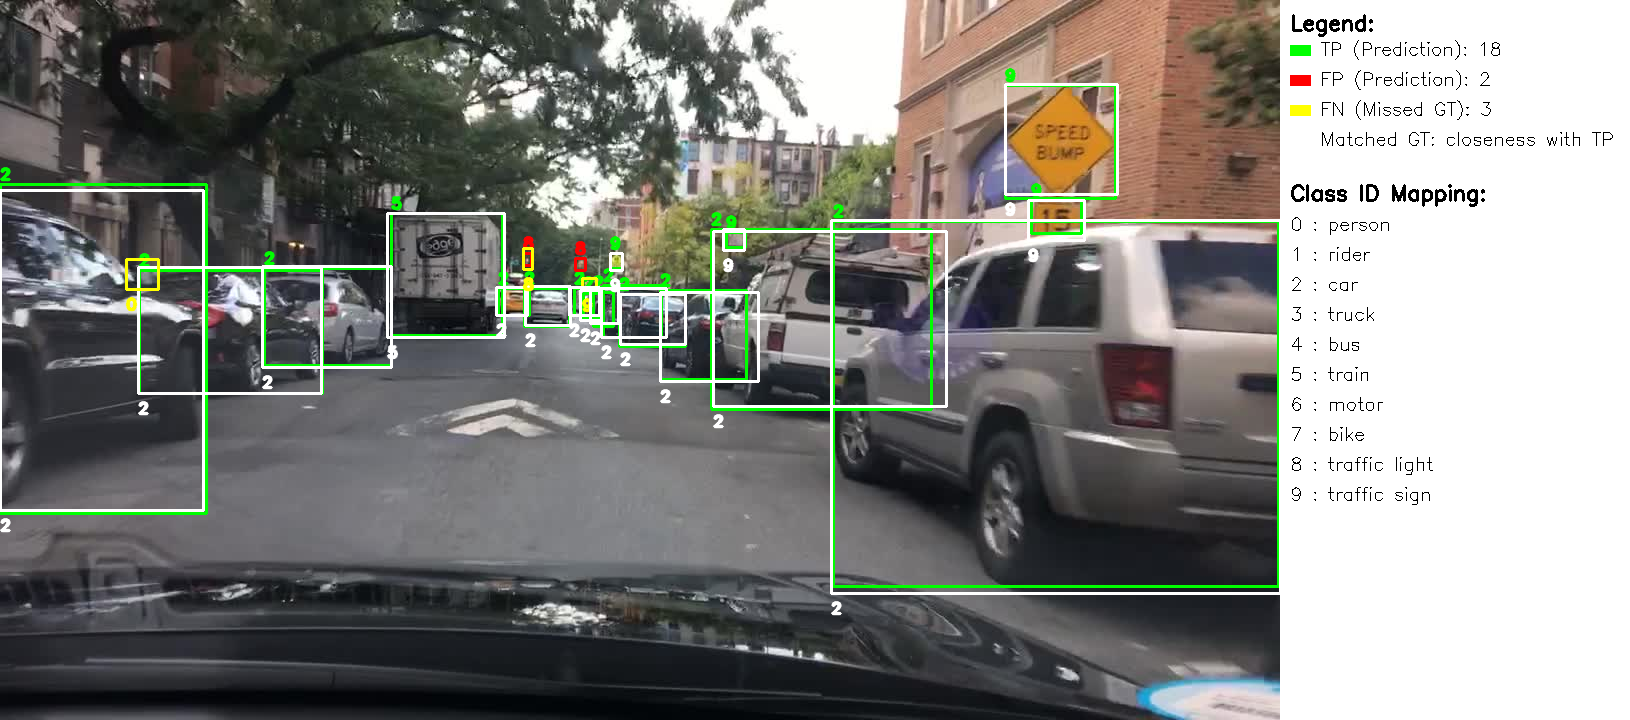

In [11]:
#display image here in html format
from IPython.display import Image, display
display(Image('/workspace/Evaluations/eval_vis_tpfpfn/b1ceb32e-a106591d_TP18_FP2_FN3.png'))

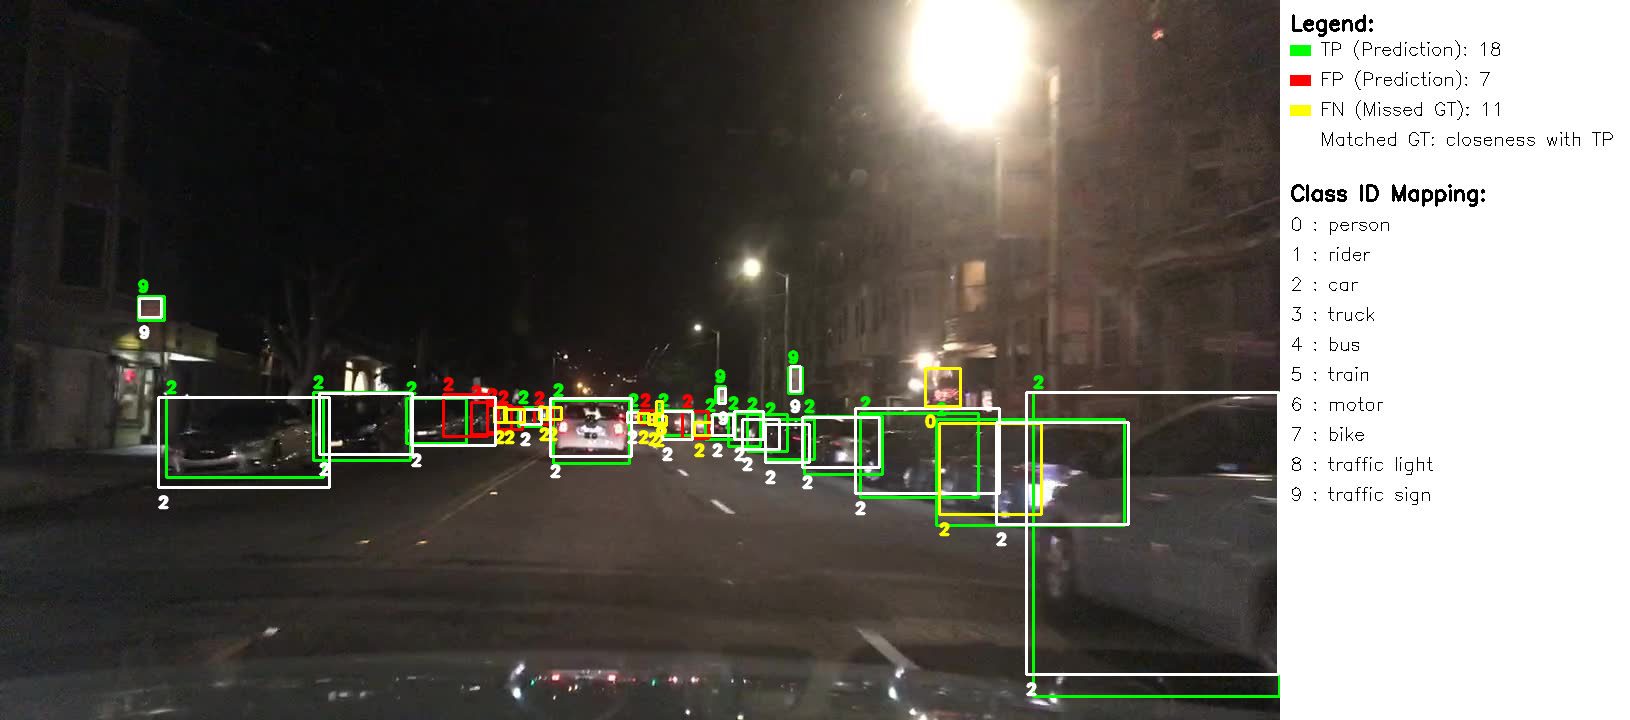

In [12]:
#display image here in html format
from IPython.display import Image, display
display(Image('/workspace/Evaluations/eval_vis_tpfpfn/b1d4b62c-d9805029_TP18_FP7_FN11.png'))

In [13]:
# #get files names in the directory with .txt extension
# txt_files = [f.split('.txt')[0] for f in os.listdir(predictions_labels_path) if f.endswith('.txt')]
# print(len(txt_files)==len(set(txt_files)))

In [14]:
# img_files = df['image_name'].unique()
# img_files=list(img_files)
# img_files=[ig.split('.jpg')[0] for ig in img_files]
# print(len(img_files)==len(set(img_files)))

#get overall metrics ; its Precision recall at conf=0.25 and iou=0.5 , no PR curve

In [23]:
def compute_overall_metrics_from_json(all_results):
    total_tp = 0
    total_fp = 0
    total_fn = 0

    for img_name, result in all_results.items():
        total_tp += result["summary"]["tp"]
        total_fp += result["summary"]["fp"]
        total_fn += result["summary"]["fn"]

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = (2 * precision * recall / (precision + recall)
          if (precision + recall) > 0 else 0)

    return {
        "tp": total_tp,
        "fp": total_fp,
        "fn": total_fn,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


compute_overall_metrics_from_json(clean_results)

{'tp': 136351,
 'fp': 48393,
 'fn': 49175,
 'precision': 0.7380537392283376,
 'recall': 0.7349428112501751,
 'f1_score': 0.7364949901423287}

#get classwise metrics ; its Precision recall at conf=0.25 and iou=0.5 , no PR curve

In [24]:
from collections import defaultdict


def compute_per_class_metrics_from_json(all_results):
    class_stats = defaultdict(lambda: {"tp": 0, "fp": 0, "fn": 0})

    for img_name, result in all_results.items():

        # Predictions → TP / FP
        for pred in result["predictions"]:
            cls_id = pred["cls_id"]

            if pred["status"] == "TP":
                class_stats[cls_id]["tp"] += 1
            elif pred["status"] == "FP":
                class_stats[cls_id]["fp"] += 1

        # Ground Truths → FN
        for gt in result["ground_truths"]:
            cls_id = gt["cls_id"]

            if gt["status"] == "FN":
                class_stats[cls_id]["fn"] += 1

    # Compute precision & recall
    per_class_metrics = {}

    for cls_id, stats in class_stats.items():
        tp = stats["tp"]
        fp = stats["fp"]
        fn = stats["fn"]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        per_class_metrics[cls_id] = {
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "precision": precision,
            "recall": recall
        }

    return per_class_metrics


compute_per_class_metrics_from_json(clean_results)

{2: {'tp': 79107,
  'fp': 21539,
  'fn': 23399,
  'precision': 0.7859924885241341,
  'recall': 0.7717304352915927},
 9: {'tp': 24877,
  'fp': 11397,
  'fn': 10031,
  'precision': 0.6858080167613166,
  'recall': 0.7126446659791452},
 8: {'tp': 18971,
  'fp': 8993,
  'fn': 7914,
  'precision': 0.6784079530825347,
  'recall': 0.705635112516273},
 1: {'tp': 336,
  'fp': 274,
  'fn': 313,
  'precision': 0.5508196721311476,
  'recall': 0.5177195685670262},
 7: {'tp': 218,
  'fp': 93,
  'fn': 234,
  'precision': 0.7009646302250804,
  'recall': 0.4823008849557522},
 5: {'tp': 2775,
  'fp': 1615,
  'fn': 1470,
  'precision': 0.6321184510250569,
  'recall': 0.6537102473498233},
 0: {'tp': 8593,
  'fp': 3694,
  'fn': 4669,
  'precision': 0.6993570440302759,
  'recall': 0.6479414869552104},
 3: {'tp': 951,
  'fp': 403,
  'fn': 646,
  'precision': 0.7023633677991138,
  'recall': 0.5954915466499687},
 6: {'tp': 523,
  'fp': 385,
  'fn': 484,
  'precision': 0.5759911894273128,
  'recall': 0.519364448

Size wise recall numbers recall at conf=0.25 and iou=0.5 

In [25]:
def get_box_area(box):
    x1, y1, x2, y2 = box
    return max(0, x2 - x1) * max(0, y2 - y1)


def categorize_size(area):
    if area < 32 * 32:
        return "small"
    elif area < 96 * 96:
        return "medium"
    else:
        return "large"

from collections import defaultdict


def compute_size_based_recall_from_json(all_results):
    size_stats = defaultdict(lambda: {"tp": 0, "fn": 0})

    for img_name, result in all_results.items():

        for gt in result["ground_truths"]:
            area = get_box_area(gt["box"])
            size_category = categorize_size(area)

            if gt["status"] == "matched":
                size_stats[size_category]["tp"] += 1
            elif gt["status"] == "FN":
                size_stats[size_category]["fn"] += 1

    size_metrics = {}

    for size, stats in size_stats.items():
        tp = stats["tp"]
        fn = stats["fn"]

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        size_metrics[size] = {
            "tp": tp,
            "fn": fn,
            "recall": recall
        }

    return size_metrics


compute_size_based_recall_from_json(clean_results)

{'medium': {'tp': 50012, 'fn': 9657, 'recall': 0.8381571670381606},
 'small': {'tp': 64340, 'fn': 38389, 'recall': 0.6263080532274236},
 'large': {'tp': 21999, 'fn': 1129, 'recall': 0.9511847111726046}}